# Analyse pour predire le prix d'un billet d'avion — modèle Random Forest

## Problématique

Le prix des billets d'avion varie selon de nombreux facteurs : compagnie aérienne, trajet, classe de voyage, nombre d'escales, ou encore l'anticipation de l'achat. Pour un voyageur ou une agence, pouvoir anticiper le prix d'un vol est une information à forte valeur.

**Dataset :** données de réservation de vols indiens disponibles sur Kaggle (`shubhambathwal/flight-price-prediction`).  
**Volume :** 300 153 lignes, 11 variables (features + variable cible).  
**Variable cible :** `price` — prix du billet en roupies indiennes.

**Objectif :** construire un modèle capable de prédire le prix d'un billet à partir des caractéristiques du vol, et identifier les variables les plus influentes sur le prix.

In [41]:
import numpy as np
import pandas as pd
import sklearn
 
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

# Prétraitement
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
 
# Prétraitement
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
 
# Modèles de Machine Learning
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

import joblib
from sklearn.tree import export_text
 
# Évaluation des modèles
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    mean_squared_error,
    r2_score
)

In [42]:
data = pd.read_csv("Clean_Dataset.csv")

print(data.head(10))

column_nan_count = data.isnull().sum()
print("NaN count per column:")
print(column_nan_count)

   Unnamed: 0   airline   flight source_city departure_time stops  \
0           0  SpiceJet  SG-8709       Delhi        Evening  zero   
1           1  SpiceJet  SG-8157       Delhi  Early_Morning  zero   
2           2   AirAsia   I5-764       Delhi  Early_Morning  zero   
3           3   Vistara   UK-995       Delhi        Morning  zero   
4           4   Vistara   UK-963       Delhi        Morning  zero   
5           5   Vistara   UK-945       Delhi        Morning  zero   
6           6   Vistara   UK-927       Delhi        Morning  zero   
7           7   Vistara   UK-951       Delhi      Afternoon  zero   
8           8  GO_FIRST   G8-334       Delhi  Early_Morning  zero   
9           9  GO_FIRST   G8-336       Delhi      Afternoon  zero   

    arrival_time destination_city    class  duration  days_left  price  
0          Night           Mumbai  Economy      2.17          1   5953  
1        Morning           Mumbai  Economy      2.33          1   5953  
2  Early_Morning     

In [43]:
print(data.describe())

          Unnamed: 0       duration      days_left          price
count  300153.000000  300153.000000  300153.000000  300153.000000
mean   150076.000000      12.221021      26.004751   20889.660523
std     86646.852011       7.191997      13.561004   22697.767366
min         0.000000       0.830000       1.000000    1105.000000
25%     75038.000000       6.830000      15.000000    4783.000000
50%    150076.000000      11.250000      26.000000    7425.000000
75%    225114.000000      16.170000      38.000000   42521.000000
max    300152.000000      49.830000      49.000000  123071.000000


In [44]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB
None


# Colonnes :
- `Unnamed: 0` : index technique, à supprimer
- `airline` : nom de la compagnie aérienne (catégorielle, 6 compagnies)
- `flight` : code de vol, à supprimer (trop spécifique, inutile pour la prédiction)
- `source_city` : ville de départ (catégorielle, 6 villes)
- `departure_time` : créneau de départ ("Early_Morning", "Morning", "Afternoon", "Evening", "Night")
- `stop` : nombre d'escales (0, 1, 2+)
- `arrival_time` : créneau d'arrivée ("Early_Morning", "Morning", "Afternoon", "Evening", "Night")
- `destination_city` : ville d'arrivée (catégorielle, 6 villes)
- `class_ticket` : classe de voyage ("Business", "Economy")
- `duration` : durée totale du vol en heures (numérique)
- `days_left` : jours restants avant le départ (numérique)
- `price` : prix du billet en roupies indiennes — **variable cible**

In [45]:
df = data.drop(columns=['Unnamed: 0'], inplace=False)
df = df.drop(columns=['flight'], inplace=False)


## Duplicates et valeurs manquantes

In [17]:
duplicate_count = df.duplicated().sum()
missing_values = df.isnull().sum()
print(f"Nombre de doublons : {duplicate_count}")
print("Valeurs manquantes par colonne :")
print(missing_values)

Nombre de doublons : 2213
Valeurs manquantes par colonne :
airline             0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class_ticket        0
duration            0
days_left           0
price               0
dtype: int64


In [18]:
df.drop_duplicates(inplace=True)
duplicate_count_after = df.duplicated().sum()
print(f"Nombre de doublons après suppression : {duplicate_count_after}")

df.dropna(subset=['price'],inplace=True)
print(f"Nombre de vols sans prix : {df['price'].isnull().sum()}")

Nombre de doublons après suppression : 0
Nombre de vols sans prix : 0


### Graphes pour visualiser la distribution et les valeurs aberrantes

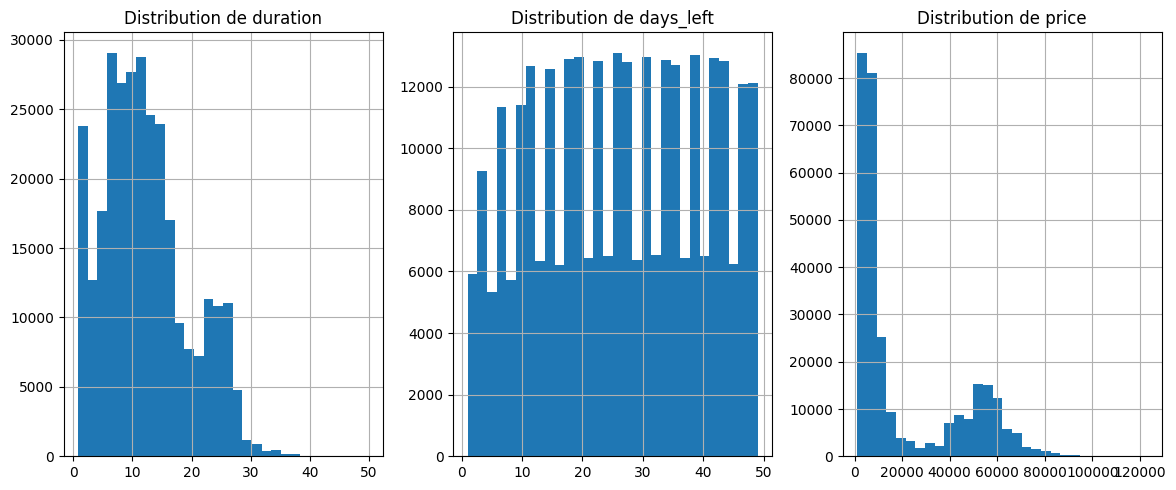

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
df.hist(column='duration', bins=30, ax=axes[0])
df.hist(column='days_left', bins=30, ax=axes[1])
df.hist(column='price', bins=30, ax=axes[2])
axes[0].set_title('Distribution de duration')
axes[1].set_title('Distribution de days_left')
axes[2].set_title('Distribution de price')
plt.tight_layout()
plt.show()

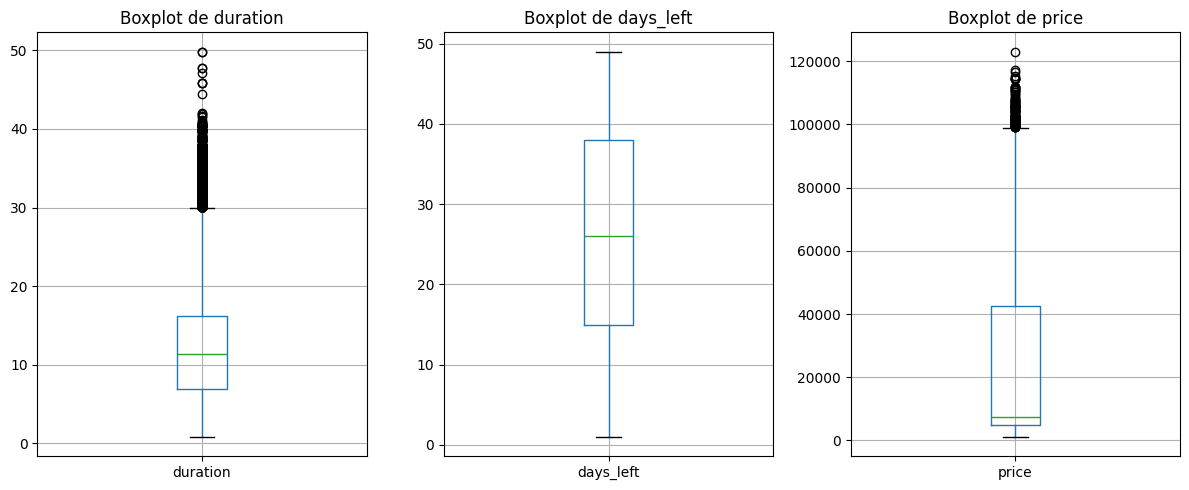

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
df.boxplot(column='duration', ax=axes[0])
df.boxplot(column='days_left', ax=axes[1])
df.boxplot(column='price', ax=axes[2])
axes[0].set_title('Boxplot de duration')
axes[1].set_title('Boxplot de days_left') 
axes[2].set_title('Boxplot de price') 
plt.tight_layout()
plt.show()

Les boxplots montrent un nombre important d'outliers sur `price` et `duration`, à prendre en compte pour la modélisation et un éventuel nettoyage futur.

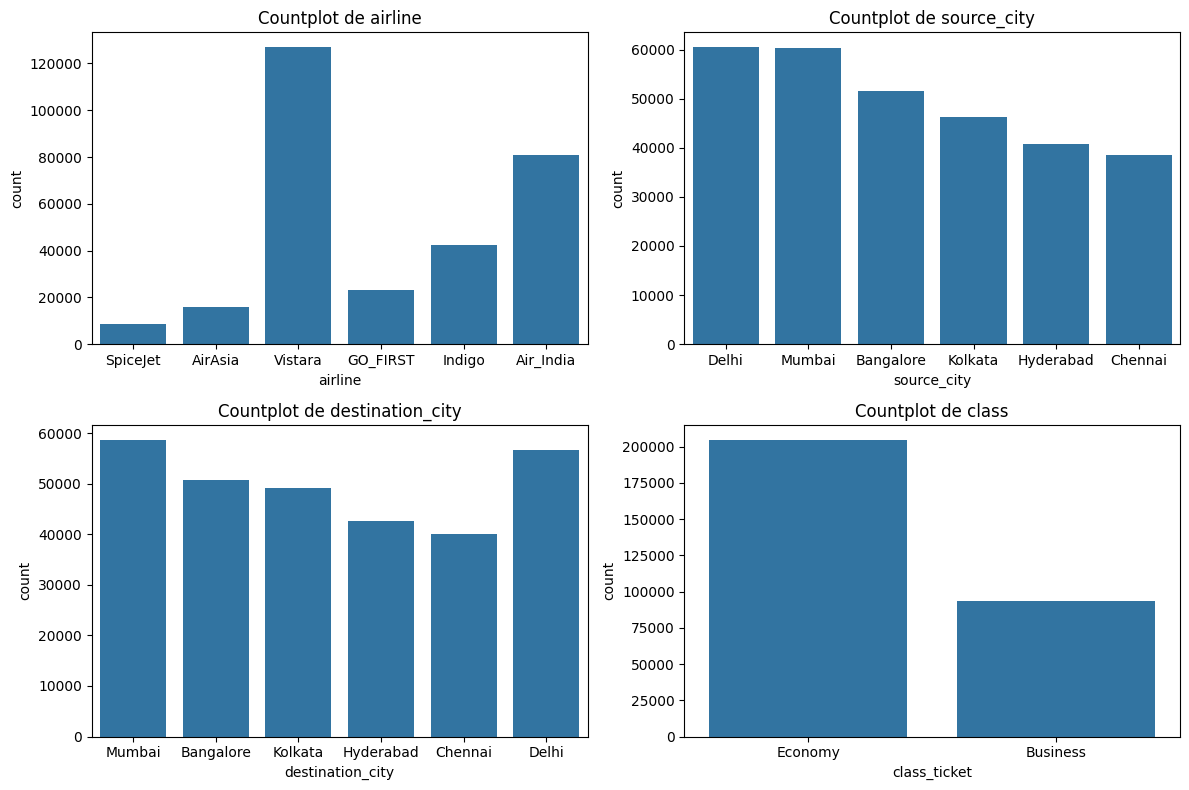

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.countplot(x=df['source_city'], ax=axes[0, 1])
axes[0, 1].set_title('Countplot de source_city')
sns.countplot(x=df['destination_city'], ax=axes[1, 0])
axes[1, 0].set_title('Countplot de destination_city')
sns.countplot(x=df['class_ticket'], ax=axes[1, 1])
axes[1, 1].set_title('Countplot de class')
sns.countplot(x=df['airline'], ax=axes[0, 0])
axes[0, 0].set_title('Countplot de airline')
plt.tight_layout()
plt.show()

La classe Economy représente environ 2/3 du dataset. La compagnie Vistara détient la majorité des vols.

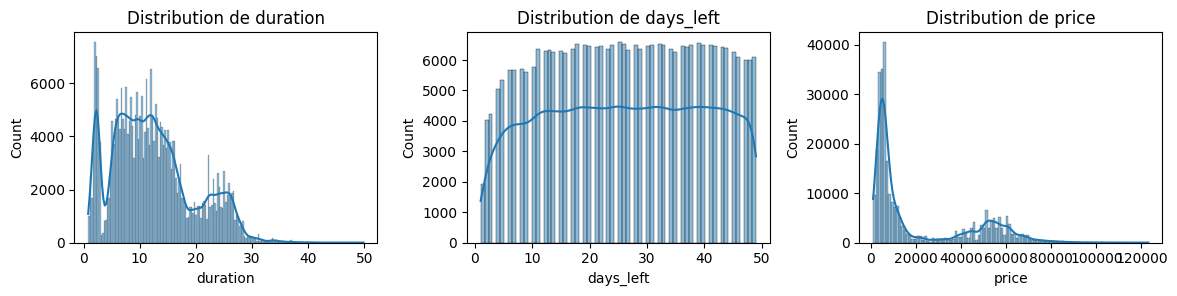

In [22]:
df_num = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
for i, column in enumerate(df_num.columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df_num[column], kde=True)
    plt.title(f'Distribution de {column}')
plt.tight_layout()
plt.show()

### Attention à la variable cible (`price`) et sa distribution

Les distributions ne sont pas normales, on a des outliers et des variables catégorielles. Les modèles linéaires (régression linéaire, ridge) ne seront pas adaptés ici car la distribution du prix est très asymétrique. On utilisera des modèles non linéaires comme Random Forest.

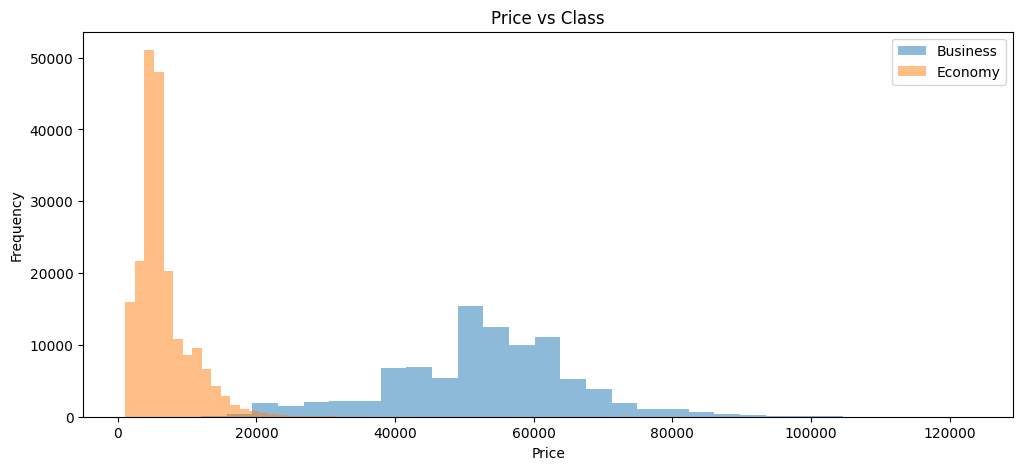

In [23]:
plt.figure(figsize=(12, 5))
pyplot.hist(df[df['class_ticket'] == 'Business']['price'], bins=30, alpha=0.5, label='Business')
pyplot.hist(df[df['class_ticket'] == 'Economy']['price'], bins=30, alpha=0.5, label='Economy')
plt.title('Price vs Class')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Le prix est très variable selon la classe : les billets Business sont nettement plus chers que les billets Economy. Cela risque de faire dominer la variable `class_ticket` dans les prédictions, au détriment des autres variables.

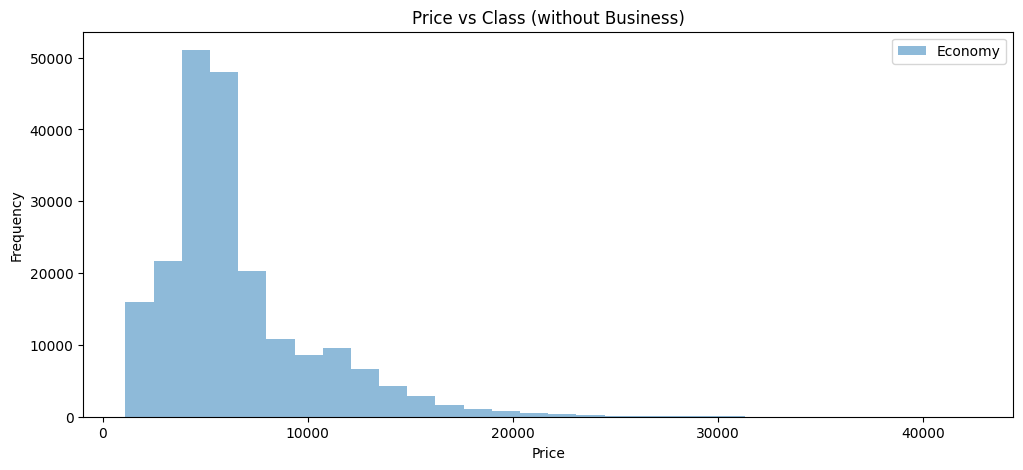

In [24]:
df_no_business = df[df['class_ticket'] != 'Business']
plt.figure(figsize=(12, 5))
pyplot.hist(df_no_business[df_no_business['class_ticket'] == 'Economy']['price'], bins=30, alpha=0.5, label='Economy')
plt.title('Price vs Class (without Business)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Pour visualiser les corrélations avec toutes les variables, on encode les catégorielles avec `OrdinalEncoder`, puis on refait la matrice de corrélation :

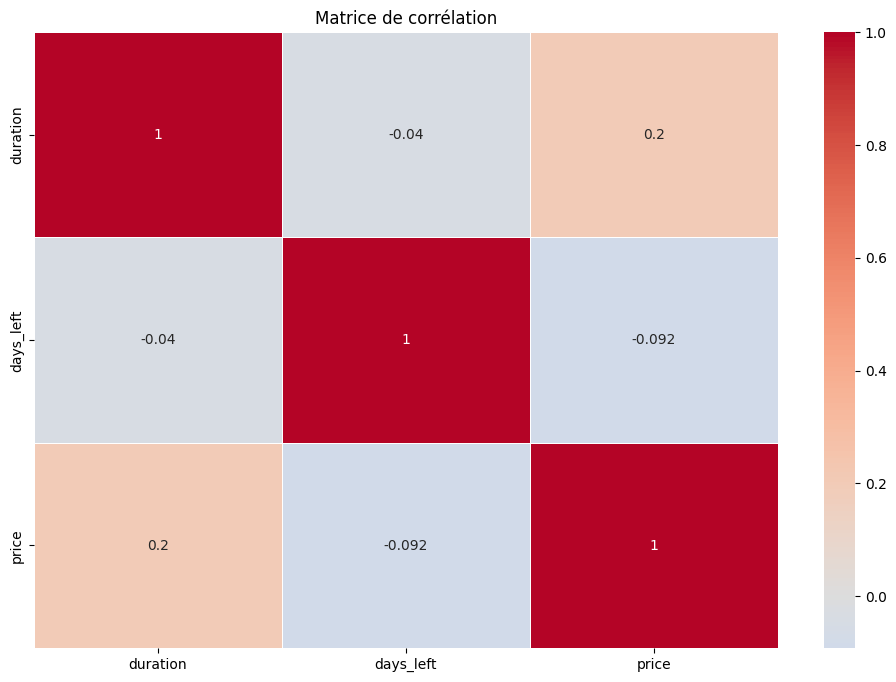

In [25]:
df_num = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
sns.heatmap(df_num.corr(), annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Matrice de corrélation')
plt.show()

Avec uniquement les variables numériques, aucune corrélation forte avec `price` n'est détectée. Cela confirme que les relations ne sont pas linéaires.

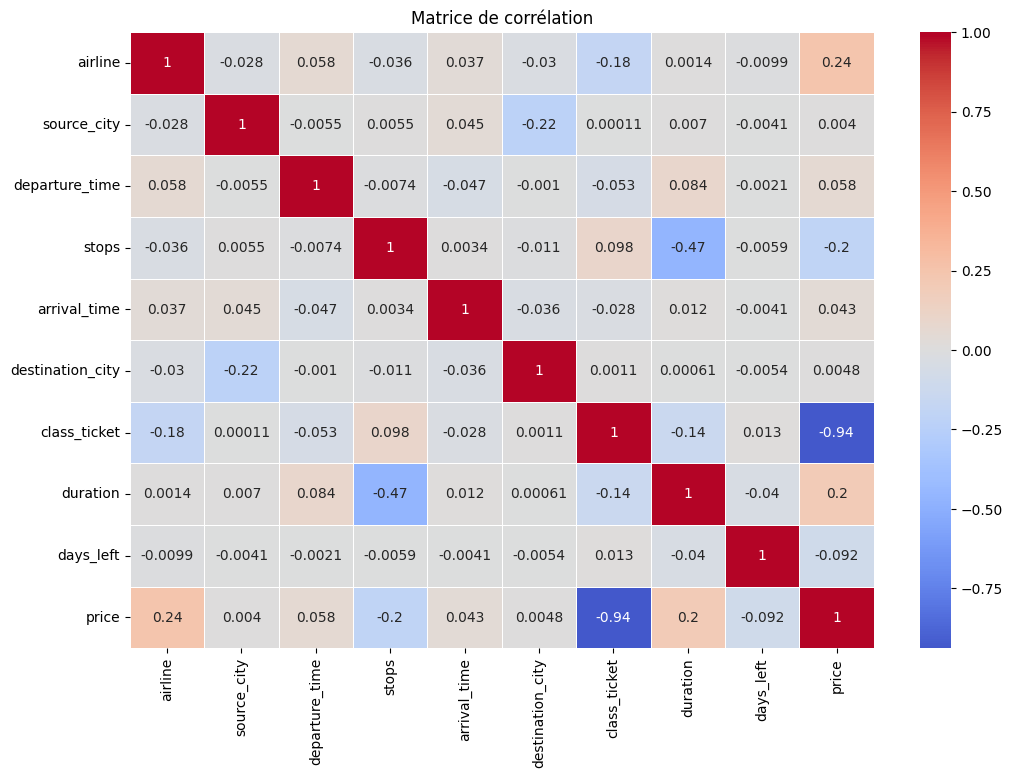

In [26]:
df2 = df.copy()
categorical_cols = df2.select_dtypes(include=['object', 'string']).columns
for col in categorical_cols:
    le = OrdinalEncoder()
    df2[col] = le.fit_transform(df2[[col]])

plt.figure(figsize=(12, 8))
sns.heatmap(df2.corr(), annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Matrice de corrélation')
plt.show()

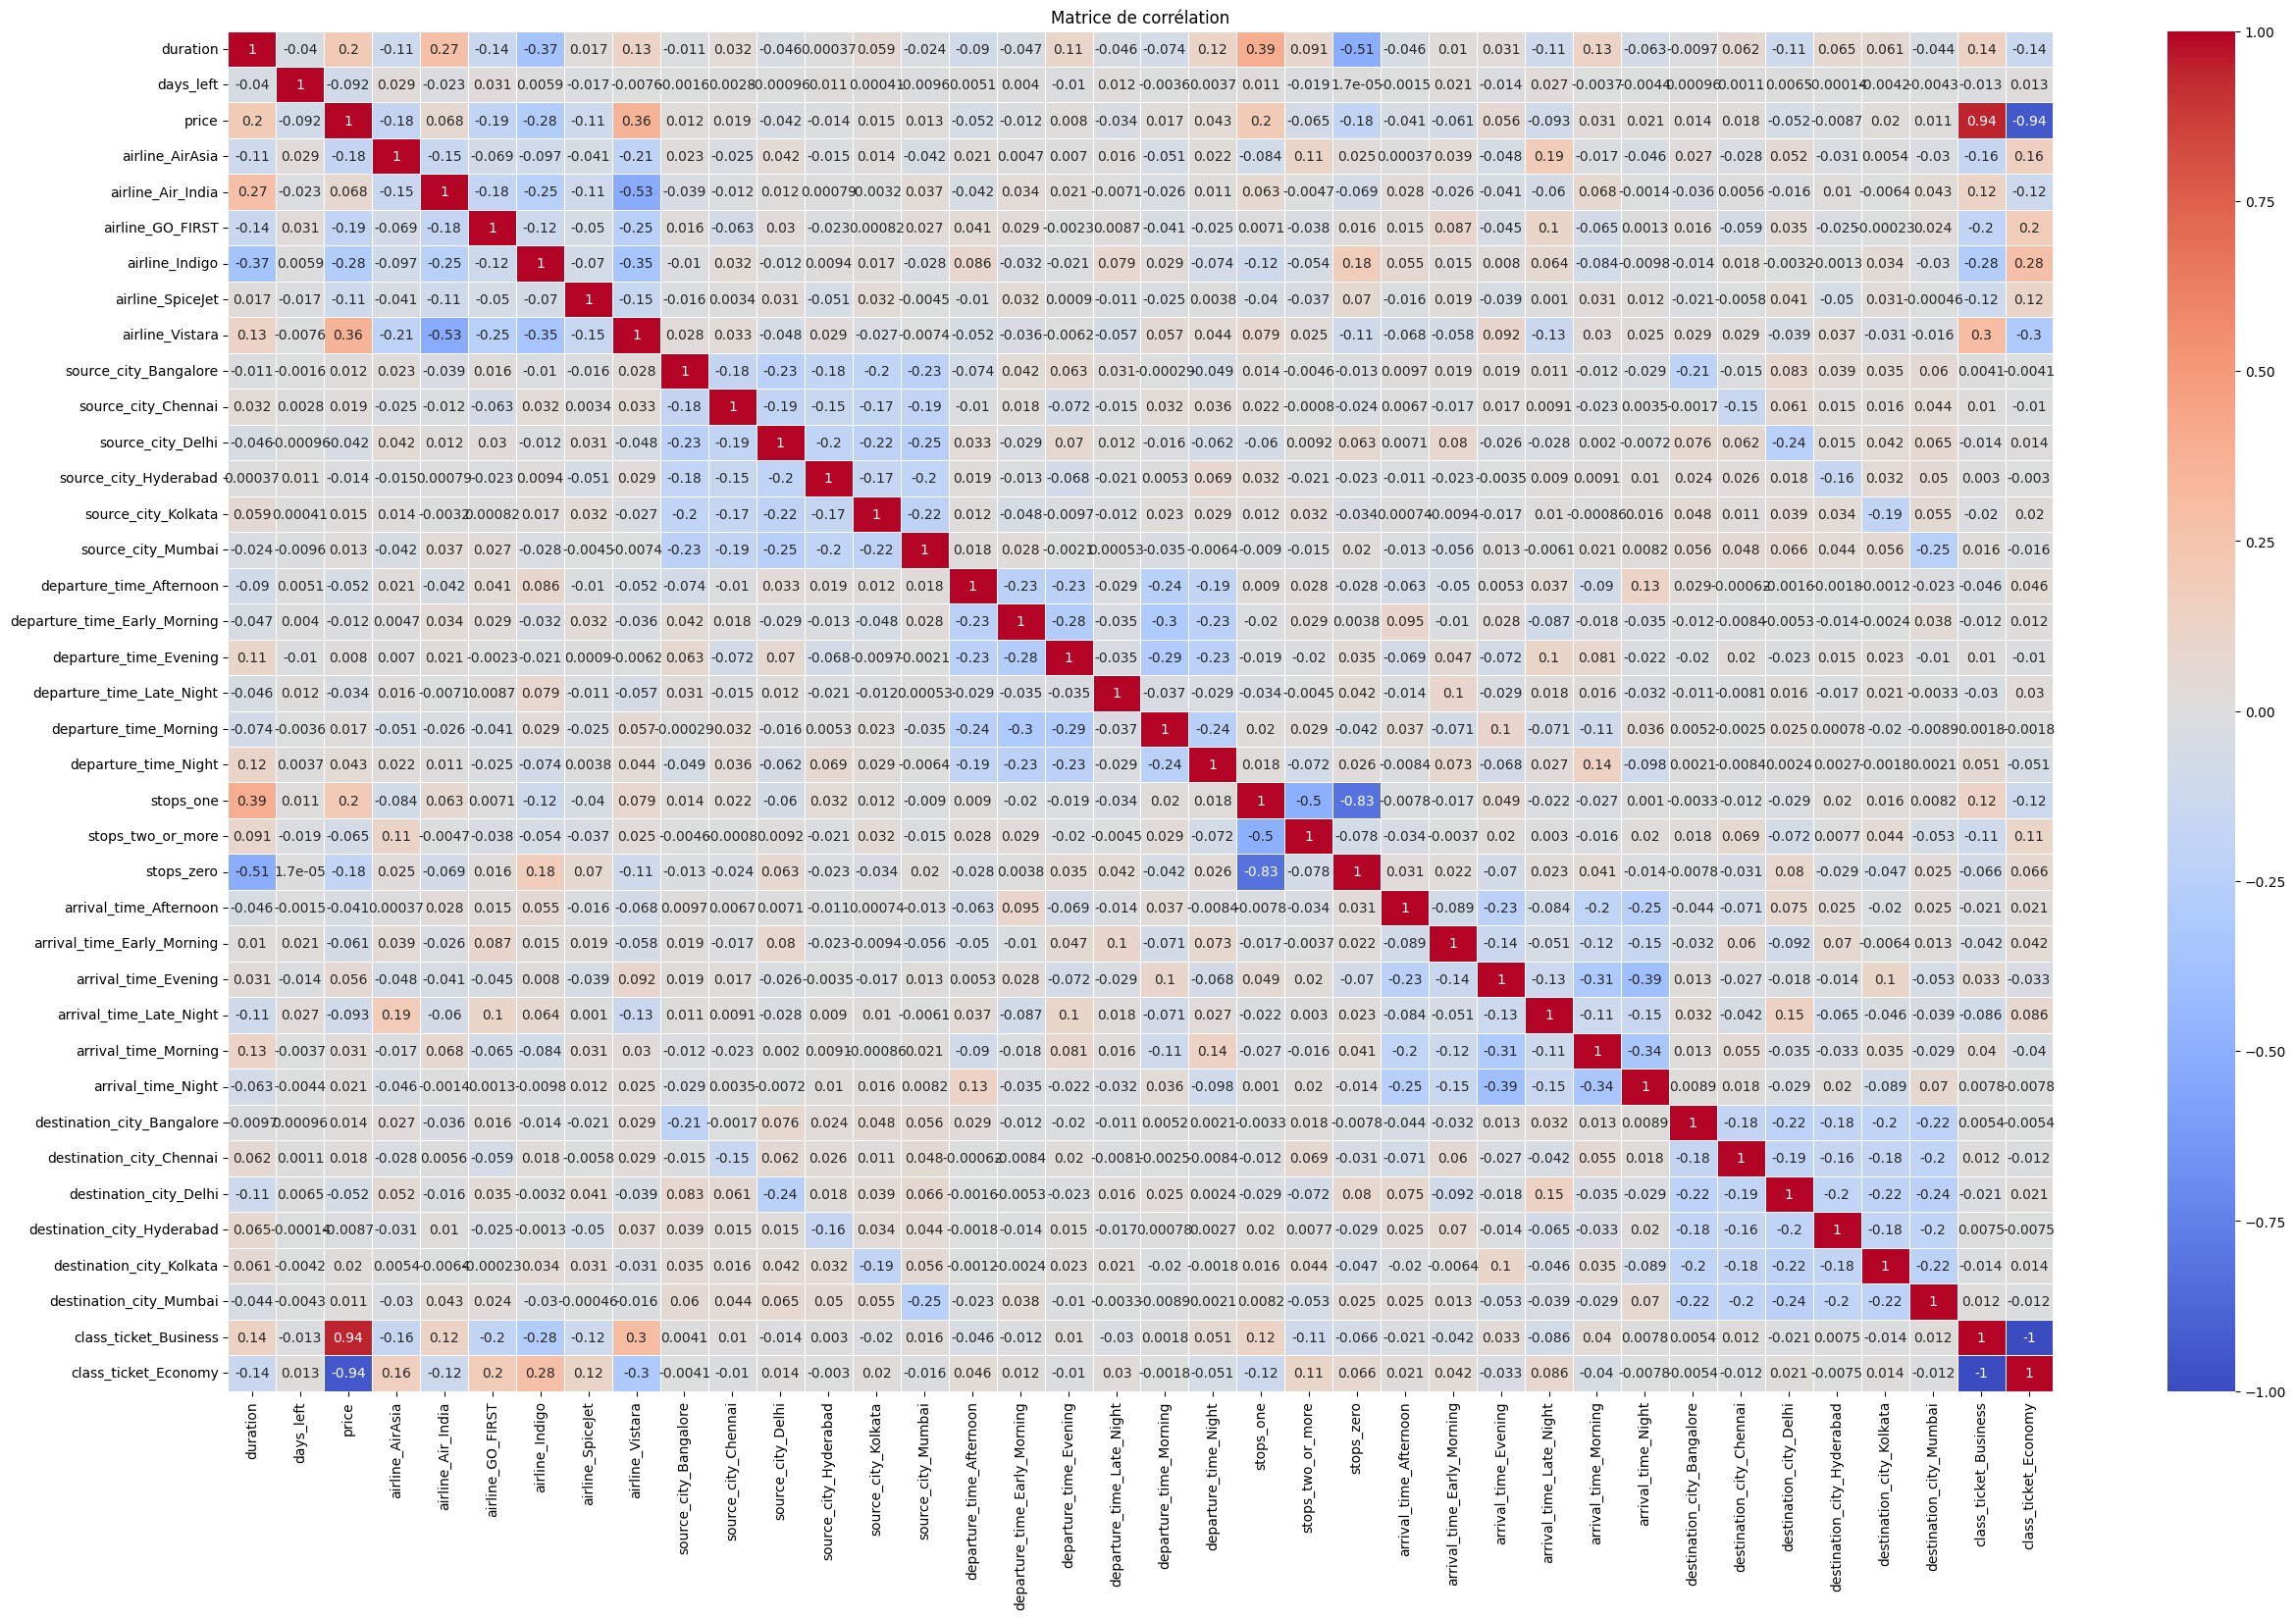

In [27]:
df3 = df.copy()
#encode les variables catégorielles using one hot encoder
categorical_cols = df3.select_dtypes(include=['object', 'string']).columns
df3 = pd.get_dummies(df3, columns=categorical_cols)

plt.figure(figsize=(30, 18))
sns.heatmap(df3.corr(), annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Matrice de corrélation')
plt.show()

Même après encodage ordinal et one-hot des variables catégorielles, il n'y a pas de corrélation linéaire forte avec `price`. Cela confirme le choix d'un modèle non linéaire.

In [28]:
print(df.columns)

Index(['airline', 'source_city', 'departure_time', 'stops', 'arrival_time',
       'destination_city', 'class_ticket', 'duration', 'days_left', 'price'],
      dtype='object')


In [29]:
X = df.drop(columns=['price'])
y = df['price']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [31]:
# Test with ONLY the 'class' feature
X_only_class = pd.get_dummies(X_train[['class_ticket']], drop_first=True)
X_only_class_test = pd.get_dummies(X_test[['class_ticket']], drop_first=True)

# Train a simple model with only class
simple_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
simple_model.fit(X_only_class, y_train)

# Predict and evaluate
y_pred_simple = simple_model.predict(X_only_class_test)
r2_simple = r2_score(y_test, y_pred_simple)
rmse_simple = np.sqrt(mean_squared_error(y_test, y_pred_simple))

print(f"Model avec SUEL 'class' :")
print(f"  R² Score: {r2_simple:.4f}")
print(f"  RMSE: {rmse_simple:.2f}")
print(f"\nR² > 0.9 indique que le modèle repose fortement sur 'class' et peut ne pas apprendre les détails fins des prix.")

Model avec SUEL 'class' :
  R² Score: 0.8790
  RMSE: 7881.91

R² > 0.9 indique que le modèle repose fortement sur 'class' et peut ne pas apprendre les détails fins des prix.


Le R² est déjà très élevé en utilisant uniquement `class_ticket`. Cela veut dire que le modèle apprend principalement la séparation Business / Economy, sans forcément capturer les détails fins des prix.

On va donc construire un modèle complet avec toutes les variables pour vérifier si les autres features apportent réellement quelque chose.

## Test : la variable `class_ticket` domine-t-elle le modèle ?

Si un modèle entraîné uniquement sur `class_ticket` atteint déjà un R² élevé, cela signifie que le modèle apprend surtout "Business → cher, Economy → moins cher", sans capturer la structure fine des prix.

## Préprocessing — Pipeline sklearn

Pour préparer les données avant la modélisation, on utilise un pipeline sklearn avec un `ColumnTransformer` :

- **Variables numériques** (`duration`, `days_left`) : imputation par médiane + `StandardScaler` pour normaliser les échelles.
- **Variables catégorielles** (compagnie, ville, créneau, escales, classe) : imputation par valeur la plus fréquente + `OneHotEncoder` pour éviter tout ordre artificiel entre les catégories.

Le pipeline est entraîné uniquement sur `X_train` pour éviter toute fuite d'information vers le jeu de test.

In [32]:
num_cols = X.select_dtypes(include=[np.number]).columns
categorical_cols = X.select_dtypes(include=['object', 'string']).columns

num_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
], verbose=True)

cat_process = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("encoder", OneHotEncoder(handle_unknown='ignore'))
], verbose=True)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_preprocess, num_cols),
        ("cat", cat_process, categorical_cols)
    ], remainder='passthrough', 
    verbose_feature_names_out=False
)

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf)
], verbose=True)

In [33]:
print(pipeline)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())],
                                                           verbose=True),
                                                  Index(['duration', 'days_left'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
         

In [34]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing scaler, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.2s
[Pipeline] ........... (step 2 of 2) Processing encoder, total=   0.4s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.7s
[Pipeline] ............. (step 2 of 2) Processing model, total= 6.3min
RMSE: 2729.7654656813793
R²: 0.9854922234990644


Le R² est très élevé et le RMSE relativement bas : les prédictions sont proches des valeurs réelles. Cependant, comme vu précédemment, une grande partie de cette performance vient de `class_ticket`.

In [35]:
imputer = pipeline.named_steps['preprocessor'].named_transformers_['num'].named_steps['imputer']
imputer_categories = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['imputer']
print(dict(zip(num_cols, imputer.statistics_)))
print(dict(zip(categorical_cols, imputer_categories.statistics_)))

{'duration': np.float64(11.33), 'days_left': np.float64(26.0)}
{'airline': 'Vistara', 'source_city': 'Delhi', 'departure_time': 'Morning', 'stops': 'one', 'arrival_time': 'Night', 'destination_city': 'Mumbai', 'class_ticket': 'Economy'}


In [36]:
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
rf_model = pipeline.named_steps['model']
importances = rf_model.feature_importances_

importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)
print(importances_df.head(10))

                    feature  importance
36     class_ticket_Economy    0.449151
35    class_ticket_Business    0.431484
0                  duration    0.056524
1                 days_left    0.018647
7           airline_Vistara    0.005029
3         airline_Air_India    0.004918
10        source_city_Delhi    0.003857
31   destination_city_Delhi    0.003263
13       source_city_Mumbai    0.002200
34  destination_city_Mumbai    0.001916


### La feature `class_ticket` domine le modèle

Comme attendu, le modèle se base principalement sur la classe de voyage pour faire ses prédictions. Economy et Business expliquent la grande majorité de la variation du prix, les autres variables (durée, escales, jours restants) ont peu de poids.

Ce résultat n'est pas faux, mais il n'est pas suffisant. On va donc séparer le dataset en deux sous-ensembles (Economy et Business) pour voir si le modèle apprend mieux les détails fins des prix sans l'effet dominant de la classe.

In [37]:
joblib.dump(pipeline, 'random_forest_flight_price.pkl')

['random_forest_flight_price.pkl']

In [38]:
loaded_model = joblib.load('random_forest_flight_price.pkl')
y_pred_loaded = loaded_model.predict(X_test)

print(f"R² Score (loaded model): {r2_score(y_test, y_pred_loaded)}")

R² Score (loaded model): 0.9854922234990644


In [39]:
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
tree = pipeline.named_steps['model'].estimators_[0]

print(export_text(tree, feature_names=list(feature_names), max_depth=4))

|--- class_ticket_Economy <= 0.50
|   |--- duration <= -1.08
|   |   |--- duration <= -1.44
|   |   |   |--- duration <= -1.49
|   |   |   |   |--- duration <= -1.53
|   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |--- duration >  -1.53
|   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |--- duration >  -1.49
|   |   |   |   |--- source_city_Hyderabad <= 0.50
|   |   |   |   |   |--- truncated branch of depth 13
|   |   |   |   |--- source_city_Hyderabad >  0.50
|   |   |   |   |   |--- value: [17738.00]
|   |   |--- duration >  -1.44
|   |   |   |--- airline_Air_India <= 0.50
|   |   |   |   |--- duration <= -1.42
|   |   |   |   |   |--- truncated branch of depth 16
|   |   |   |   |--- duration >  -1.42
|   |   |   |   |   |--- truncated branch of depth 23
|   |   |   |--- airline_Air_India >  0.50
|   |   |   |   |--- duration <= -1.37
|   |   |   |   |   |--- truncated branch of depth 14
|   |   |   |   |--- duration >  -1.37
|   |   |   |   |  

## Conclusion

Ce modèle de base donne des résultats très élevés sans nettoyage poussé, ce qui s'explique principalement par le poids de la variable `class_ticket` dans la prédiction.

La limite principale : le modèle capte peu les variations fines liées à la durée, aux escales ou aux jours restants. Les analyses Economy et Business séparées permettront de vérifier si ces variables ont plus d'influence une fois la classe retirée.

## Analyse business et impact

**Impact métier :** un modèle de prédiction de prix permet à un voyageur d'identifier les conditions les plus favorables pour acheter un billet (anticipation, classe, trajet). Pour une compagnie aérienne, il peut servir à mieux comprendre la structure de sa grille tarifaire et à identifier les segments les plus sensibles au prix.

**Limites :**
- La variable `class_ticket` domine largement les prédictions. Le modèle global apprend surtout la différence entre Business et Economy, pas les nuances de prix au sein d'une même classe.
- Les données couvrent uniquement le marché indien sur une période limitée — la généralisation à d'autres marchés n'est pas directement applicable.

**Perspectives :**
- Les analyses séparées Economy et Business (voir notebooks dédiés) permettent de mieux isoler les variables fines comme `duration`, `days_left` et `stop`.
- Une analyse non supervisée par K-Means a été menée en parallèle (`exam_analysis_KMeans_unsupervised.ipynb`) pour segmenter les vols par profil tarifaire, sans utiliser le prix comme cible.